In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


C:\Users\chenja1\AppData\Local\Temp\ipykernel_18912\3174971943.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


In [159]:
# feature engineering maintenance duration

hvacdata['date_closing'] = pd.to_datetime(hvacdata['date_closing'], errors='coerce')
hvacdata['date_maintenance_action'] = pd.to_datetime(hvacdata['date_maintenance_action'], errors='coerce')

hvacdata = hvacdata.dropna(subset=['date_closing', 'date_maintenance_action'])


hvacdata['maintenance_duration'] = (
    hvacdata['date_closing'] - hvacdata['date_maintenance_action']
).dt.days

# drop negatives
hvacdata.loc[hvacdata['maintenance_duration'] < 0, 'maintenance_duration'] = pd.NA
hvacdata = hvacdata.dropna(subset=['maintenance_duration'])



In [160]:
hvacdata['date_maintenance_action'] = pd.to_datetime(hvacdata['date_maintenance_action'], errors='coerce')

# group by `ship` to find the earliest date
first_maintenance_dates = (
    hvacdata.groupby('ship')['date_maintenance_action']
    .min()
    .reset_index()
    .rename(columns={'date_maintenance_action': 'first_maintenance_date'})
)

print(first_maintenance_dates)


     ship first_maintenance_date
0   CVN68             2017-11-02
1   CVN69             2017-11-01
2   CVN70             2017-11-01
3   CVN71             2017-11-04
4   CVN72             2017-11-01
5   CVN73             2017-11-02
6   CVN74             2017-11-01
7   CVN75             2017-11-02
8   CVN76             2017-11-01
9   CVN77             2017-11-01
10  CVN78             2017-11-01


In [161]:
hvacdata = hvacdata.merge(first_maintenance_dates, on='ship', how='left')


In [162]:
# column for calendar month
hvacdata['calendar_month'] = hvacdata['date_maintenance_action'].dt.to_period('M')


In [163]:
# calculate time since start of maintenance jobs

hvacdata['months_since_first_maintenance'] = (
    (hvacdata['date_maintenance_action'] - hvacdata['first_maintenance_date']) / np.timedelta64(1, 'M')
)


hvacdata['months_since_first_maintenance'] = (
    hvacdata['months_since_first_maintenance']
    .round()
    .astype('Int64')
)

hvacdata = hvacdata[hvacdata['ship'].notna()]


In [164]:
print(hvacdata[['ship', 'date_maintenance_action', 'first_maintenance_date', 'months_since_first_maintenance']].head())

    ship date_maintenance_action first_maintenance_date  \
0  CVN72              2022-05-30             2017-11-01   
1  CVN72              2022-05-30             2017-11-01   
2  CVN72              2022-05-30             2017-11-01   
3  CVN72              2022-05-30             2017-11-01   
4  CVN72              2022-05-30             2017-11-01   

   months_since_first_maintenance  
0                              54  
1                              54  
2                              54  
3                              54  
4                              54  


In [165]:
hvacdata['computed_total_material_cost'] = hvacdata['unit_price'] * hvacdata['quantity']


In [166]:
job_summary = (
    hvacdata.groupby(['ship', 'months_since_first_maintenance'])
    .agg(
        num_jobs=('ship', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)

print(job_summary.head(10))


    ship  months_since_first_maintenance  num_jobs  total_material_cost
0  CVN68                               0       132            1184.8200
1  CVN68                               1        82            5883.6300
2  CVN68                               2       162           19929.8225
3  CVN68                               3       418           51977.9175
4  CVN68                               4       298            9381.6250
5  CVN68                               5       158           40127.1800
6  CVN68                               6       272            8689.8650
7  CVN68                               7       194           28921.8525
8  CVN68                               8       112            4791.1425
9  CVN68                               9       112            7569.3500


In [167]:
# groups data by ship, calendar_month, and part


monthly_part_summary = (
    hvacdata.groupby(['ship', 'calendar_month', 'niin_nomenclature'])
    .agg(
        total_part_quantity=('quantity', 'sum'),
        num_jobs=('job_status', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)


print(monthly_part_summary.head(20))


     ship calendar_month    niin_nomenclature  total_part_quantity  num_jobs  \
0   CVN68        2017-11               BELT,V                  4.0         2   
1   CVN68        2017-11   CONTACTOR,MAGNETIC                  2.0         2   
2   CVN68        2017-11   FILTER ELEMENT,AIR                160.0       142   
3   CVN68        2017-11  RELAY,ELECTROMAGNET                  2.0         2   
4   CVN68        2017-12   FILTER ELEMENT,AIR                 12.0        10   
5   CVN68        2017-12  HEATING ELEMENT,ELE                  2.0         2   
6   CVN68        2017-12   PARTS KIT,PRESSURE                  2.0         2   
7   CVN68        2017-12  PARTS KIT,REGULATIN                  2.0         2   
8   CVN68        2017-12  RELAY,ELECTROMAGNET                  2.0         2   
9   CVN68        2017-12                 RING                  4.0         4   
10  CVN68        2017-12       RING,RETAINING                  4.0         4   
11  CVN68        2017-12    TRANSFORMER,

# Predicting Filters for CVN 68

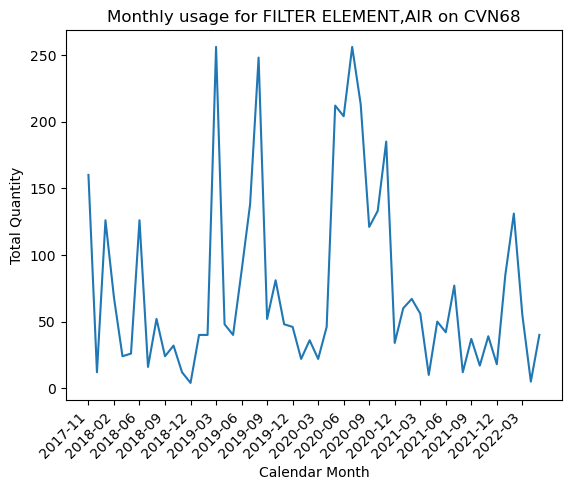

In [168]:
import matplotlib.pyplot as plt

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
]

plt.plot(part_data['calendar_month'].astype(str), part_data['total_part_quantity'])
plt.title(f"Monthly usage for {part} on {ship}")
plt.xlabel('Calendar Month')
plt.ylabel('Total Quantity')

# every 3rd month for readability
plt.xticks(
    ticks=range(0, len(part_data['calendar_month']), 3),
    labels=part_data['calendar_month'].astype(str)[::3],
    rotation=45,
    ha='right'
)

plt.show()


     calendar_month  total_part_quantity  rolling_avg_quantity
2           2017-11                160.0                   NaN
4           2017-12                 12.0                   NaN
17          2018-01                126.0             99.333333
27          2018-02                 68.0             68.666667
37          2018-03                 24.0             72.666667
46          2018-04                 26.0             39.333333
72          2018-06                126.0             58.666667
90          2018-07                 16.0             56.000000
98          2018-08                 52.0             64.666667
110         2018-09                 24.0             30.666667
121         2018-10                 32.0             36.000000
129         2018-11                 12.0             22.666667
136         2018-12                  4.0             16.000000
145         2019-01                 40.0             18.666667
157         2019-02                 40.0             28

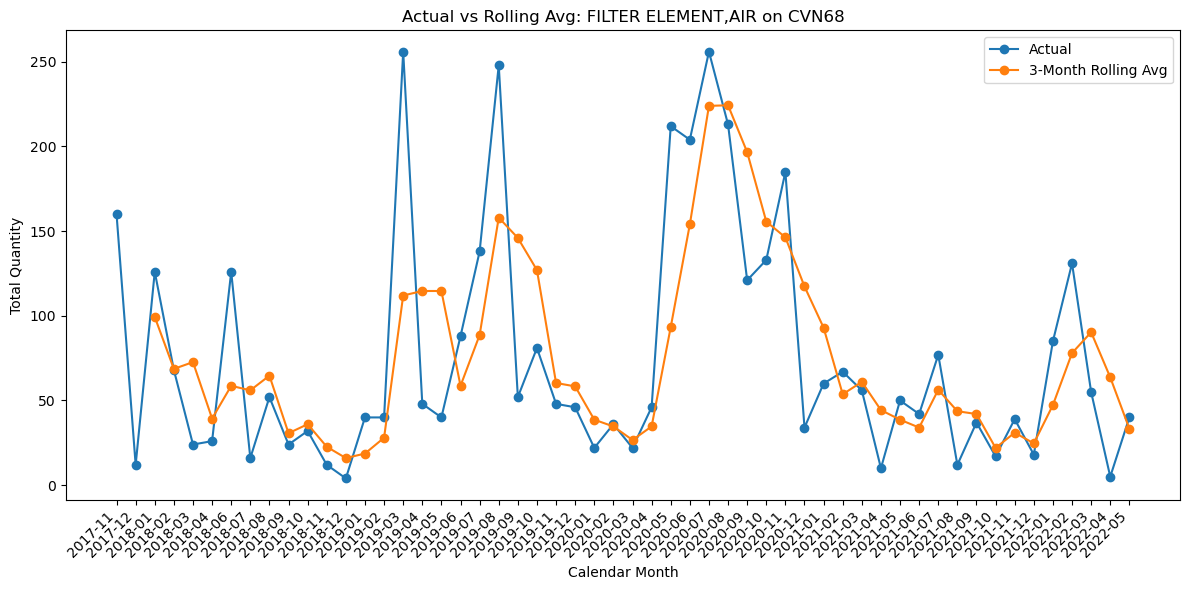

In [169]:
# rolling average column for quantity, smooth demand trend for better forecasting insight
# mean of current month and the previous 2 months
part_data = part_data.sort_values('calendar_month')
part_data['rolling_avg_quantity'] = part_data['total_part_quantity'].rolling(window=3).mean()

print(part_data[['calendar_month', 'total_part_quantity', 'rolling_avg_quantity']])


plt.figure(figsize=(12, 6))
plt.plot(part_data['calendar_month'].astype(str), part_data['total_part_quantity'], marker='o', label='Actual')
plt.plot(part_data['calendar_month'].astype(str), part_data['rolling_avg_quantity'], marker='o', label='3-Month Rolling Avg')
plt.title(f'Actual vs Rolling Avg: {part} on {ship}')
plt.xlabel('Calendar Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [170]:
# test model


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# calendar_month sorted
part_data = part_data.sort_values('calendar_month').reset_index(drop=True)

# convert calendar_month to an integer index for regression
part_data['month_index'] = np.arange(len(part_data))

X = part_data[['month_index']]
y = part_data['total_part_quantity']


In [171]:
# last 5 months for testing

X_train, X_test = X[:-3], X[-3:]
y_train, y_test = y[:-3], y[-3:]


model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [172]:
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# actual vs predicted
results = pd.DataFrame({
    'calendar_month': part_data['calendar_month'][-3:].astype(str),
    'actual': y_test,
    'predicted': y_pred
})
print(results)



Mean Squared Error: 2679.06
   calendar_month  actual  predicted
51        2022-03    55.0  80.566275
52        2022-04     5.0  80.654419
53        2022-05    40.0  80.742564


# Prophet Model
models seasonality (certain months consistently see more usage?) trends automatically
identifies general trend (are quantities increasing/decresing over months?)
Model works better with more data (months) to train

In [173]:


import pandas as pd

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

# summary table for this filter & cvn 68
part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
].copy()

# date, Prophet takes in timestamp format
part_data['ds'] = part_data['calendar_month'].apply(lambda x: x.to_timestamp())

# predicting the number of parts needed
part_data['y'] = part_data['total_part_quantity']

# these are the only two required columns for prophet
prophet_data = part_data[['ds', 'y']].sort_values('ds')

print(prophet_data.tail())


             ds      y
1012 2022-01-01   85.0
1025 2022-02-01  131.0
1045 2022-03-01   55.0
1063 2022-04-01    5.0
1068 2022-05-01   40.0


In [174]:
from prophet import Prophet

# hold out last 5 months for training/testing
train = prophet_data.iloc[:-5]
test = prophet_data.iloc[-5:]

# prophet model
model = Prophet()

# fit model to part_data
model.fit(train)

print(test)



12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


             ds      y
1012 2022-01-01   85.0
1025 2022-02-01  131.0
1045 2022-03-01   55.0
1063 2022-04-01    5.0
1068 2022-05-01   40.0


In [175]:
# future dataframe, extend dates to predict 10 months ahead (this includes train/test)
future = model.make_future_dataframe(periods=10, freq='MS') # MS = month-start
forecast = model.predict(future)


In [176]:
forecast_eval = forecast[['ds', 'yhat']].merge(
    prophet_data[['ds', 'y']], on='ds', how='left'
)

print(forecast_eval.tail(30))


           ds        yhat      y
29 2020-05-01  154.468101  212.0
30 2020-06-01  128.534517  204.0
31 2020-07-01  147.507914  256.0
32 2020-08-01   68.344511  213.0
33 2020-09-01   47.456335  121.0
34 2020-10-01   49.404771  133.0
35 2020-11-01  133.230341  185.0
36 2020-12-01    7.261347   34.0
37 2021-01-01   91.506129   60.0
38 2021-02-01   80.013770   67.0
39 2021-03-01   58.593723   56.0
40 2021-04-01   31.241286   10.0
41 2021-05-01  113.835042   50.0
42 2021-06-01  118.457208   42.0
43 2021-07-01  128.949219   77.0
44 2021-08-01  109.230462   12.0
45 2021-09-01   54.384955   37.0
46 2021-10-01   60.144584   17.0
47 2021-11-01  100.779751   39.0
48 2021-12-01   17.389170   18.0
49 2022-01-01   70.772954   85.0
50 2022-02-01   60.049810  131.0
51 2022-03-01  118.217312   55.0
52 2022-04-01   32.859657    5.0
53 2022-05-01   72.748848   40.0
54 2022-06-01  108.797901    NaN
55 2022-07-01  111.371181    NaN
56 2022-08-01  150.628562    NaN
57 2022-09-01   60.890079    NaN
58 2022-10

In [177]:
print("Predictions for test period:")
print(forecast_eval[forecast_eval['ds'].isin(test['ds'])])


Predictions for test period:
           ds        yhat      y
49 2022-01-01   70.772954   85.0
50 2022-02-01   60.049810  131.0
51 2022-03-01  118.217312   55.0
52 2022-04-01   32.859657    5.0
53 2022-05-01   72.748848   40.0


# Random Forest Model

In [178]:
# text engineering (preprocess)

def_narrative_patterns = {
    'maintenance_related': r'\bmaintenance|pm|preventive maintenance|inspection|check|routine\b',
    'repair_related': r'\brepair|troubleshoot|fix|correct\b',
    'replacement_related': r'\breplace|new|install|procure\b',
    'cleaning_related': r'\bclean|vacuum|wash\b',
    'corrosion_related': r'\bcorrosion|rust|preserve\b',
    'fan_related': r'\bfan\b',
    'coil_related': r'\bcoil\b',
    'filter_related': r'\bfilter\b',
    'motor_related': r'\bmotor\b',
    'valve_related': r'\bvalve\b',
    'switch_related': r'\bswitch\b',
    'belt_related': r'\bbelt\b'
}

def create_binary_features(df, column, patterns):
    features = {}
    for key, pattern in patterns.items():
        features[f'{column}_{key}'] = df[column].astype(str).str.contains(pattern, case=False, regex=True, na=False).astype(int)
    return pd.DataFrame(features)
    

def_narrative_features = create_binary_features(hvacdata, 'def_narrative', def_narrative_patterns)

hvacdata = pd.concat([hvacdata, def_narrative_features], axis=1)

hvacdata['calendar_month'] = hvacdata['date_maintenance_action'].dt.to_period('M').dt.to_timestamp()



Test MSE: 140.53
   calendar_month  actual  predicted
49     2022-01-01    85.0      78.84
50     2022-02-01   131.0     135.75
51     2022-03-01    55.0      74.67
52     2022-04-01     5.0      18.28
53     2022-05-01    40.0      48.88

Feature Importances:
                                     feature  importance
2                                   num_jobs    0.424839
6               def_narrative_filter_related    0.123411
3                   avg_maintenance_duration    0.097306
8          def_narrative_replacement_related    0.096021
5                              avg_days_open    0.088317
4             total_ship_force_man_hours_sum    0.056107
7          def_narrative_maintenance_related    0.045462
0                                      month    0.025068
1                                       year    0.022982
10  component_status_mode_Reduced capability    0.019523
9          component_status_mode_Operational    0.000962


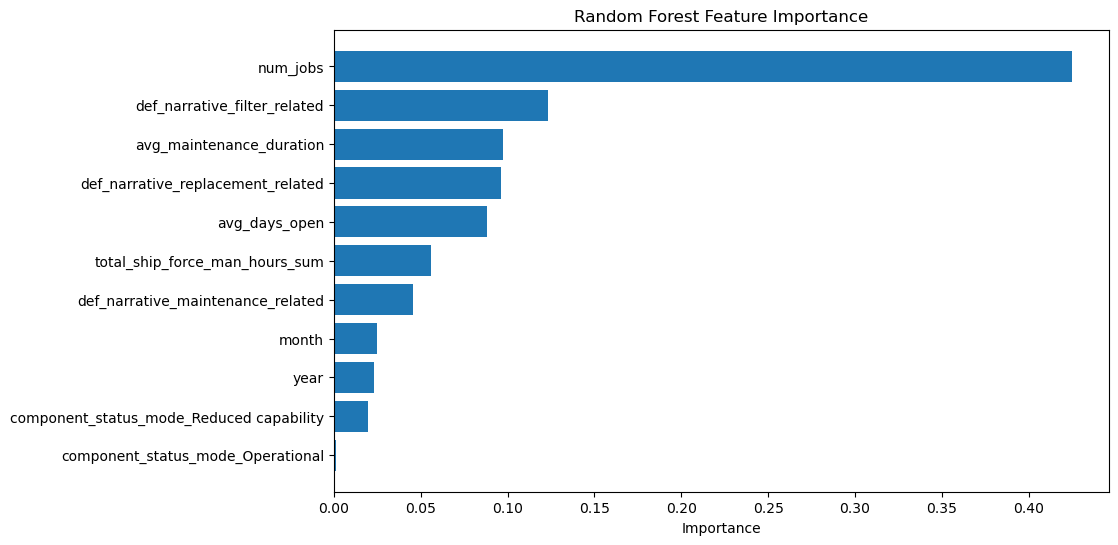

In [185]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# monthly_part_summary: ship, niin_nomenclature, calendar_month, total_part_quantity, num_jobs, total_material_cost

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

df = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
].copy()


df['calendar_month'] = df['calendar_month'].dt.to_timestamp()
df['month'] = df['calendar_month'].dt.month
df['year'] = df['calendar_month'].dt.year

# lag features that helps model learn from prior months
# e.g. if last month was high, maybe next month will be high  as well
df['quantity_lag1'] = df['total_part_quantity'].shift(1)



# extra features
extra_features = (
    hvacdata.groupby(['ship', 'calendar_month', 'niin_nomenclature'])
    .agg(
        avg_maintenance_duration=('maintenance_duration', 'mean'),
        total_ima_man_hours_sum=('total_ima_man_hours', 'sum'),
        total_ship_force_man_hours_sum=('total_ship_force_man_hours', 'sum'),
        avg_days_open=('days_open', 'mean'),
        type_availability_code_mode=('type_availability_code', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        component_status_mode=('component_status', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        type_of_maintenance_action_mode=('type_of_maintenance_action', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        type_of_availability_needed_mode=('type_of_availability_needed', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        def_narrative_filter_related=('def_narrative_filter_related', 'sum'),
        def_narrative_maintenance_related=('def_narrative_maintenance_related', 'sum'),
        def_narrative_replacement_related=('def_narrative_replacement_related', 'sum'),
    )
    .reset_index()
)



# merging extra features to df
df = df.merge(
    extra_features,
    on=['ship', 'calendar_month', 'niin_nomenclature'],
    how='left'
)

df = df.dropna()



# feature selection
X = df[[
    'month', 'year', 'num_jobs', 'avg_maintenance_duration',
    'total_ship_force_man_hours_sum', 'avg_days_open',
    'def_narrative_filter_related', 'def_narrative_maintenance_related',
    'component_status_mode',
    'def_narrative_replacement_related'
]]

# One-hot encode
X = pd.get_dummies(X, columns=['component_status_mode',], drop_first=True)

y = df['total_part_quantity']

# (last 5 months as test)
train_size = int(len(df) - 5)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

results = pd.DataFrame({
    'calendar_month': df['calendar_month'].iloc[train_size:].astype(str),
    'actual': y_test,
    'predicted': y_pred
})
print(results)


# feature importances
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()



In [186]:
print(hvacdata['component_status'].unique())



['Operational' 'Non-operational'
 'Not applicable (when reporting printing services, etc)'
 'Reduced capability']


## used the same code/model but for a different ship (cvn75), but seems like separate models must me made. could be due to irregular part usage, fewer consistent maintenance jobs, more outliers, etc.

In [187]:
monthly_part_summary.groupby('ship')['calendar_month'].nunique()


ship
CVN68    55
CVN69    54
CVN70    54
CVN71    55
CVN72    55
CVN73     8
CVN74    41
CVN75    55
CVN76    55
CVN77    55
CVN78    54
Name: calendar_month, dtype: int64

In [188]:
hvacdata = hvacdata.loc[:, ~hvacdata.columns.duplicated()]


In [189]:
print(hvacdata.columns)


Index(['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin',
       'csmp_narrative_summary', 'date_closing', 'date_maintenance_action',
       'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature',
       'eswbs_opening', 'identification_number_closing', 'iuc_screening_code',
       'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code',
       'status_code', 'tycom_screening_code', 'type_availability_code',
       'type_of_maintenance_action', 'when_discovered_code', 'work_center',
       'total_ima_man_hours', 'total_ship_force_man_hours',
       'total_replacement_cost', 'total_repair_replacement_cost',
       'def_narrative', 'nondef_narrative', 'closing_narrative',
       'ima_narrative', 'total_material_cost', 'opening_ship_system',
       'closing_ship_system', 'job_status', 'days_open', 'action_taken',
       'intermediate_unit_commander_screening', 'priority', 'component_status',
       'type_of_availability_needed', 'tycom_screening', 'when_discovered',
  

# XGBoost for CVN 68 filters (best model so far)


Best Parameters Found: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Tuned XGBoost Test MSE: 106.29
   calendar_month  actual   predicted
49     2022-01-01    85.0   71.491455
50     2022-02-01   131.0  138.104141
51     2022-03-01    55.0   62.942429
52     2022-04-01     5.0   20.050375
53     2022-05-01    40.0   42.987404

XGBoost Feature Importances:
                                     feature  importance
2                                   num_jobs    0.240457
7               def_narrative_filter_related    0.226082
6                              avg_days_open    0.139071
4                   avg_maintenance_duration    0.092724
8          def_narrative_replacement_related    0.087892
10  component_status_mode_Reduced capability    0.079773
1                                       year    0.036532
5             total_ship_force_man_hours_sum    0.032044
3                              quantity_lag1    0.031616
0            

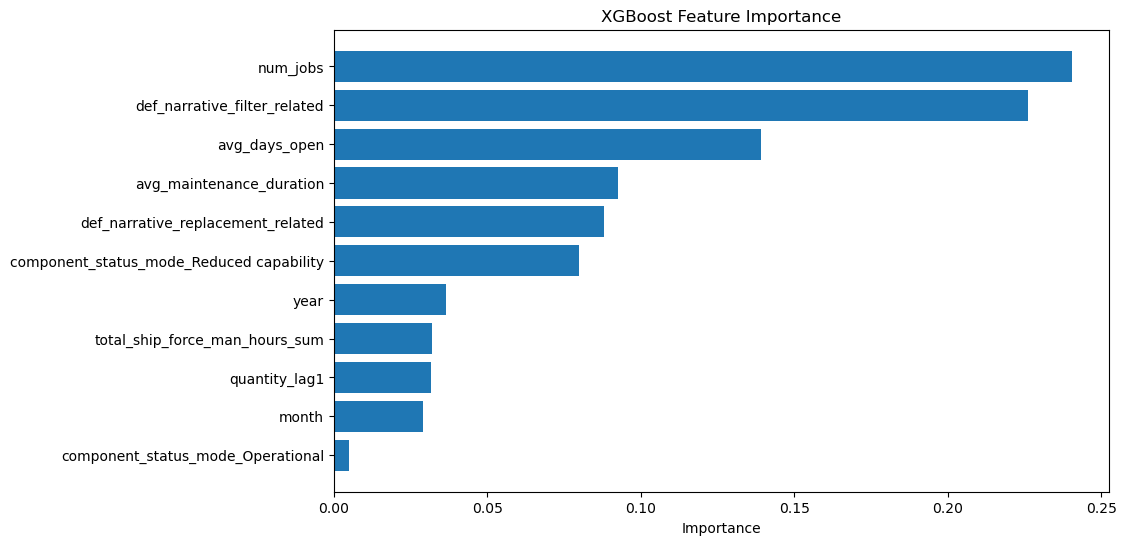

In [192]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

df_xgb = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
].copy()

df_xgb['calendar_month'] = df_xgb['calendar_month'].dt.to_timestamp()
df_xgb['month'] = df_xgb['calendar_month'].dt.month
df_xgb['year'] = df_xgb['calendar_month'].dt.year
df_xgb['quantity_lag1'] = df_xgb['total_part_quantity'].shift(1)

# extra features
extra_features_xgb = (
    hvacdata.groupby(['ship', 'calendar_month', 'niin_nomenclature'])
    .agg(
        avg_maintenance_duration=('maintenance_duration', 'mean'),
        total_ship_force_man_hours_sum=('total_ship_force_man_hours', 'sum'),
        avg_days_open=('days_open', 'mean'),
        component_status_mode=('component_status', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        def_narrative_filter_related=('def_narrative_filter_related', 'sum'),
        def_narrative_maintenance_related=('def_narrative_maintenance_related', 'sum'),
        def_narrative_replacement_related=('def_narrative_replacement_related', 'sum'),
    )
    .reset_index()
)

df_xgb = df_xgb.merge(extra_features_xgb, on=['ship', 'calendar_month', 'niin_nomenclature'], how='left')
df_xgb = df_xgb.dropna()

# features
X_xgb = df_xgb[[
    'month', 'year', 'num_jobs', 'quantity_lag1',
    'avg_maintenance_duration', 'total_ship_force_man_hours_sum',
    'avg_days_open', 'def_narrative_filter_related',
    'component_status_mode',
    'def_narrative_replacement_related'
]]

X_xgb = pd.get_dummies(X_xgb, columns=['component_status_mode'], drop_first=True)
y_xgb = df_xgb['total_part_quantity']

# split
train_size_xgb = int(len(df_xgb) - 5)
X_train_xgb, X_test_xgb = X_xgb.iloc[:train_size_xgb], X_xgb.iloc[train_size_xgb:]
y_train_xgb, y_test_xgb = y_xgb.iloc[:train_size_xgb], y_xgb.iloc[train_size_xgb:]


# hyperparameter tuning
param_dist = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_for_search = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_for_search,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train_xgb)

print("\nBest Parameters Found:", random_search.best_params_)



# model
xgb_model = random_search.best_estimator_

# predict
y_pred_xgb = xgb_model.predict(X_test_xgb)

mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
print(f"\nTuned XGBoost Test MSE: {mse_xgb:.2f}")

results_xgb = pd.DataFrame({
    'calendar_month': df_xgb['calendar_month'].iloc[train_size_xgb:].astype(str),
    'actual': y_test_xgb,
    'predicted': y_pred_xgb
})
print(results_xgb)


# feature importance
import matplotlib.pyplot as plt
import pandas as pd

# feature importance
xgb_importance_df = pd.DataFrame({
    'feature': X_train_xgb.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(xgb_importance_df)

# plot
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['feature'], xgb_importance_df['importance'])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()



test 12

In [2]:
import sys
print(sys.executable)

C:\Users\chenja1\AppData\Local\anaconda3\python.exe
